In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/CV_Project_3

/content/gdrive/MyDrive/CV_Project_3


In [15]:
# !unzip cityscapes.zip

In [8]:
import glob
import os
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from sklearn.metrics import jaccard_score
from tensorflow.keras.layers import Input
import tensorflow as tf
from models import vgg16_unet, unet, yolov3
from sklearn.utils import shuffle
from utils import generators
import configparser
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU, Precision, Recall, F1Score, BinaryIoU
from tensorflow.keras.losses import BinaryFocalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import ParameterGrid

config = configparser.ConfigParser()
config.read('settings.ini')


['settings.ini']

In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. Switch to a GPU runtime in Colab.")

Default GPU Device: /device:GPU:0


In [5]:
test_file_paths = glob.glob(config['Paths']['test'])

WINDOW_WIDTH = int(config['Shapes']['WINDOW_WIDTH'])
WINDOW_HEIGHT = int(config['Shapes']['WINDOW_HEIGHT'])
IMAGE_WIDTH = int(config['Shapes']['IMAGE_WIDTH'])
IMAGE_HEIGHT = int(config['Shapes']['IMAGE_HEIGHT'])

window_input_img = Input(shape=(WINDOW_HEIGHT, WINDOW_WIDTH, 3))
input_img = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

### Prepare YOLO

In [6]:
yolo = yolov3.YOLOv3_human(IMAGE_WIDTH, IMAGE_HEIGHT, threshold_probability=0.8, threshold_iou=0.3)

### Prepare VGG-UNet

In [9]:
def iou_loss(y_true, y_pred):
    ''' based on
        Rahman, M.A. and Wang, Y., 2016, December. Optimizing intersection-over-union in deep neural networks for
        image segmentation. In International symposium on visual computing (pp. 234-244). Springer, Cham.
           https://fse.studenttheses.ub.rug.nl/18139/1/AI_BA_2018_FlorisvanBeers.pdf
        code source:
        https://github.com/yingkaisha/keras-unet-collection/blob/f0fb7d8fbf2837d46a6bd7936a53856f018edb8e/keras_unet_collection/losses.py#L425

     '''
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true,tf.float32)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)

    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))

    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect

    return 1-tf.math.divide_no_nan(area_intersect, area_union)

model = vgg16_unet.VGG16_UNet(window_input_img, doBatchNorm = True, learning_rate =  1e-3, optimizer='rmsprop', loss_function=iou_loss)
net = model.network()
net.compile(loss=model.loss,
                    metrics=[BinaryIoU(name='binary_iou'), Precision(), Recall(), 'accuracy'],
                    optimizer=model.optimizer)
net.load_weights('checkpoint_0.3_True_<function iou_loss at 0x7a374745a320>_rmsprop.h5')

### Prepare data generator

In [10]:
batch_size = 32
test_generator = generators.DataGenerator(test_file_paths, rescale=False, complementary='instance')

### Yolo sanity check

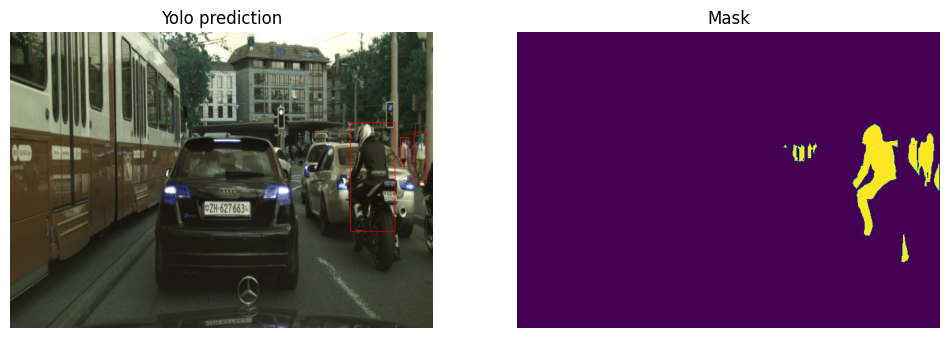

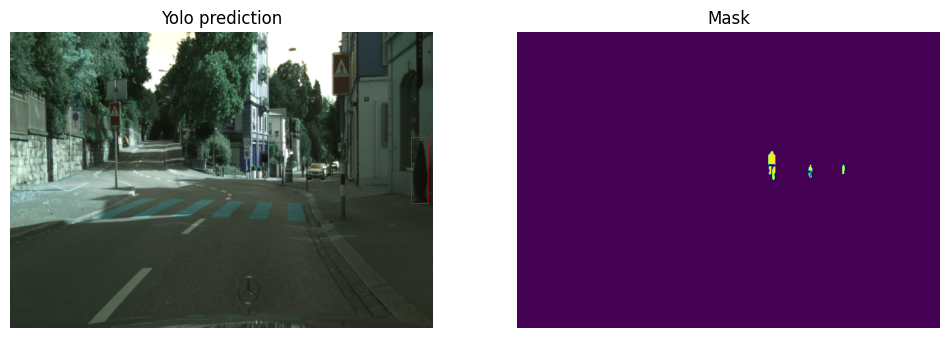

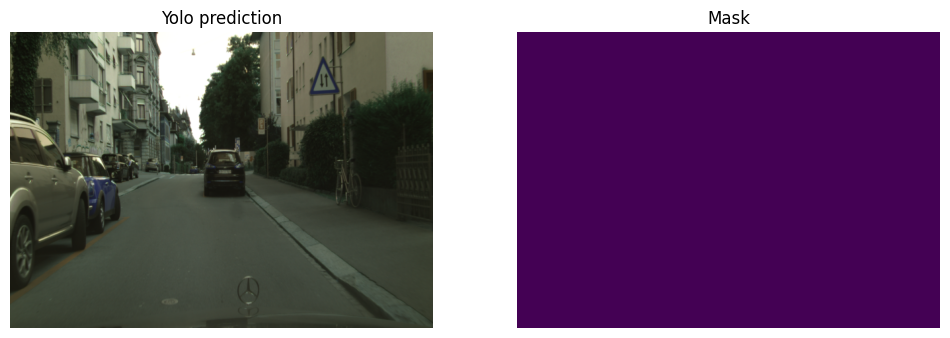

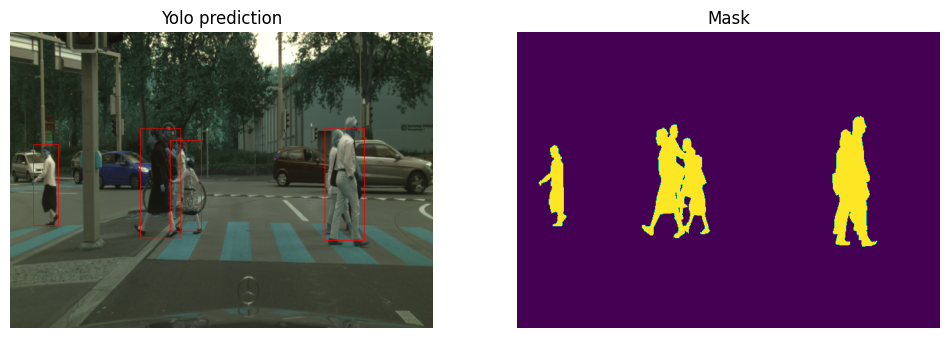

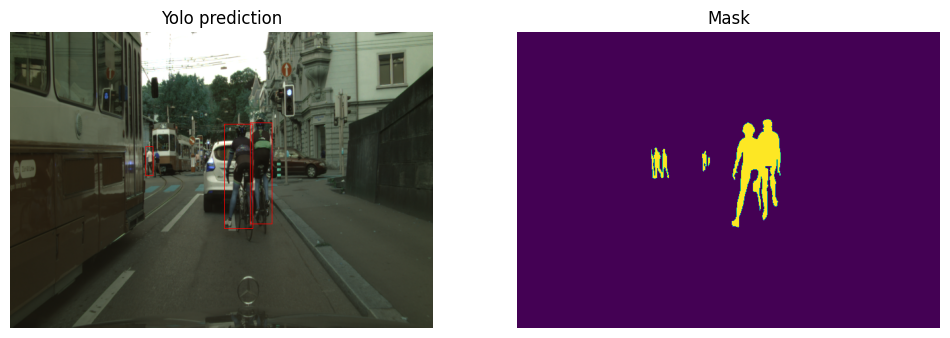

In [36]:
batch = test_generator[0]
random_indices = random.sample(range(len(batch[0])), 5)

for i in random_indices:
    input_image = batch[0][i]
    boxes, confs = yolo.detect((input_image*255).astype('uint8'))
    gt = batch[1][i][:, :, 0]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(yolo.visualize_image(input_image, boxes, confs))
    axes[0].set_title('Yolo prediction')
    axes[0].axis('off')

    axes[1].imshow((gt!=0).astype('uint8'))
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

### Final architecture

In [11]:
mean_exact_match = 0.0
mean_iou = 0.0

for batch in test_generator:
  masks = batch[0]
  images = batch[1]
  for image, ground_truth_mask in zip(masks, images):
    # (0) prepare mask
    id = 0
    instance_mask = np.zeros_like(ground_truth_mask)
    num_instances = np.max((ground_truth_mask*255).astype('uint'))
    # (1) object detection
    boxes, confs = yolo.detect((image*255).astype('uint8'))
    valid_boxes = [(x, y, w, h) for (x, y, w, h) in boxes if x>=0 and y>=0]
    yolo_patch_images = [image[y:y+h, x:x+w] for (x, y, w, h) in valid_boxes]
    window_images = np.array([cv2.resize(patch, (WINDOW_WIDTH, WINDOW_HEIGHT), interpolation=cv2.INTER_AREA) for patch in yolo_patch_images])
    # (2) semantic segmentation
    unet_output_masks = []
    for img in window_images:
      pred = net.predict(img[np.newaxis, ...], verbose=0 )[0]
      unet_output_masks.append((pred>=0.5).astype('uint8'))
    # (3) connect together
    unet_output_masks_resized = [np.expand_dims(cv2.resize(mask, (yolo_patch_images[i].shape[1], yolo_patch_images[i].shape[0]), interpolation=cv2.INTER_NEAREST), axis=-1) for i, mask in enumerate(unet_output_masks)]
    for i, out_mask in enumerate(unet_output_masks_resized):
      (x, y, w, h) = valid_boxes[i]
      instance_mask[y:y+h, x:x+w] = out_mask*(id+1)
      id +=1

    # update stats
    if num_instances != 0:
      mean_exact_match += min(id, num_instances)/num_instances
    else:
      if id==0:
        # if both detected 0, add a match
        mean_exact_match +=1
    mean_iou += jaccard_score((ground_truth_mask!=0).astype('uint8').flatten(), (instance_mask!=0).astype('uint8').flatten(), zero_division=1.0)

    # visualisation
    #print(f"{id}/{num_instances} instances detected.")
    # fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    # axes[0].imshow(image)
    # axes[0].set_title('Input Image')
    # axes[0].axis('off')

    # axes[1].imshow(instance_mask)
    # axes[1].set_title('Prediction')
    # axes[1].axis('off')

    # axes[2].imshow(ground_truth_mask)
    # axes[2].set_title('Ground truth')
    # axes[2].axis('off')
    # plt.show()

print(f"mean_exact_match = {mean_exact_match/100} mean_iou = {mean_iou/100}")

mean_exact_match = 0.3931464026758421 mean_iou = 0.4692390012969363
